In [179]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import pandas_market_calendars as mcal
import matplotlib.pyplot as plt

import tkinter as tk


from Parameters import Portfolio_GUI, Rf_index 
from Data_Processing import * 
from BLP import BLP 
from Hedge import * 
from Investment_action import * 
from Signal import z_score 

from Performance import Performance_Analysis 

#### Interface of parameters for the portfolio construction

In [180]:

# Create the main window and pass it to the Portfolio GUI class
root = tk.Tk()
interface= Portfolio_GUI(root)
root.mainloop()

# Initial investement amount
Capital = interface.capital
# Percentage of liquidity reserved at the beginning
liquid_reserve = interface.liquid_reserves
# Rebalance Frequency
frequency=interface.frequency
# Obervation periode for ShareBuyback Program
lookback_horizon = interface.lookback_horizon

country = interface.country
# Percentage of retaining cash to buy new stocks
new_cash_use_percent = 0.5


## I. Data Preparation

In [181]:
# import stocks 
print('country study: ',country)
print('horizon study: ', lookback_horizon)
df_database = get_data(lookback_horizon, country)
df_database.head()

country study:  US
horizon study:  2y


,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30
0,AA UN Equity,AA UN Equity,AA UN Equity,AA UN Equity,AA UN Equity,AA UN Equity,AA UN Equity,AA UN Equity,AAPL UW Equity,AAPL UW Equity,AAPL UW Equity,AAPL UW Equity,AAPL UW Equity,AAPL UW Equity,AAPL UW Equity
1,AAP UN Equity,AAP UN Equity,AAPL UW Equity,AAPL UW Equity,AAPL UW Equity,AAPL UW Equity,AAPL UW Equity,AAPL UW Equity,ABNB UW Equity,ABNB UW Equity,ABNB UW Equity,ABNB UW Equity,ABNB UW Equity,ABNB UW Equity,ABNB UW Equity
2,AAPL UW Equity,AAPL UW Equity,ABNB UW Equity,ABNB UW Equity,ABNB UW Equity,ABNB UW Equity,ABNB UW Equity,ABNB UW Equity,ACGL UW Equity,ACGL UW Equity,ACGL UW Equity,ACGL UW Equity,ACGL UW Equity,ACGL UW Equity,ACGL UW Equity
3,ABNB UW Equity,ABNB UW Equity,ACGL UW Equity,ACGL UW Equity,ACGL UW Equity,ACGL UW Equity,ACGL UW Equity,ACGL UW Equity,ACN UN Equity,ACN UN Equity,ACN UN Equity,ACN UN Equity,ACN UN Equity,ACN UN Equity,ACN UN Equity
4,ACGL UW Equity,ACGL UW Equity,ACM UN Equity,ACM UN Equity,ACM UN Equity,ACM UN Equity,ACM UN Equity,ACN UN Equity,AGNC UW Equity,AGNC UW Equity,AGNC UW Equity,AGNC UW Equity,AGNC UW Equity,ADBE UW Equity,ADBE UW Equity


In [182]:
# The ticker for the company CNH Industrial has been changed on Bloomberg. 
# To be able to get its historical price, we will update the database manually to reflect this change.
df_database.replace('CNHI UN Equity', 'CNH UN Equity', inplace=True)

In [183]:
# get the start & end date of the observation period
bgn_horizon = df_database.columns[0]
end_horizon = df_database.columns[-1]
print('Backtest begin time :',bgn_horizon)
print('Backtest end date: ', end_horizon)

# https://pypi.org/project/pandas-market-calendars/
# Get business day calendar
nyse = mcal.get_calendar('NYSE')

Backtest begin time : 2023-02-28
Backtest end date:  2024-04-30


## II. Portfolio Construction

In [184]:
# Initialize Bloomberg API connection
blp = BLP()

# creation of the function to simplify the code of sending Bloomberg Request
def run_bloomberg(tickers, strFields, valid_bgn_date, end_date):
    dict_output = blp.bdh(strSecurity=tickers, strFields=strFields, startdate=valid_bgn_date.date(), enddate=end_date)
    if strFields == ['PX_LAST', 'BETA_ADJ_OVERRIDABLE']:
        df_price = dict_output['PX_LAST']
        df_beta = dict_output['BETA_ADJ_OVERRIDABLE']
        return df_price, df_beta
    else:
        df_price = dict_output['PX_LAST']
        return df_price

In [185]:
# Initialization for the portfolio
strFields = ["PX_LAST", "BETA_ADJ_OVERRIDABLE"]                 # list of the fields we need to retrieve from Bloomberg
rebalance = Rebalance(bgn_horizon, end_horizon, frequency)      # creation of the object "Rebalance"
rebalance_month_list = rebalance.rebalance_month()              # generate the list of rebalance month during our investment horizon


today = dt.datetime.now()
value_ptf = Capital                                             # get the initial value of portfolio
df_value=pd.DataFrame(columns=['ptf_value'])   
dict_PORT_info = dict()                                           # the dictionary who save the necessary for PORT construction in bloomberg (ticker & price)
dict_name_list=[]

pt_value = get_point_value(country)                             # calculate the value of 1.0 pt of the future contract based on the country
pnl_futures = []                             



# Loop through each time point in the database to manage and rebalance the portfolio
for t in range(df_database.shape[1]):
#for t in range(3): 
    ptf_memb_cur = df_database.iloc[:,t] # Current members of the portfolio at time t
    ptf_memb_cur.dropna(inplace=True)  # get components of our portfolio at time t

    tickers = ptf_memb_cur
    bgn_date = pd.to_datetime(df_database.columns[t])

    # Determine the end date based on conditions:
    # if the bgn_date is in the same month of today, we get the PX_LAST until today, otherwise we get the daily price for the whole month
    if t < df_database.shape[1]-1:
        end_date = pd.to_datetime(df_database.columns[t+1])
    elif bgn_date + timedelta(days=30) > today:
        end_date = today
    else:
        end_date = bgn_date + timedelta(days=30)
    print("t = ",t)
    # using mcal package to get the business trading date
    valid_bgn_date = mcal.date_range(nyse.schedule(start_date=bgn_date, end_date=end_date), frequency='1D')[0]
    valid_end_date = mcal.date_range(nyse.schedule(start_date=end_date, end_date=end_date+timedelta(days=7)), frequency='1D')[0]

    # ====== step 1. whether or not rebalence month (include the initial time) ====== 
    if bgn_date in rebalance_month_list:
        # calculate the market value of the portfolio at the rebalance date (business day)
        if t == 0:
            value_ptf = value_ptf # When t= 0, no change to portfolio value
        else:
            # # Reevaluate the portfolio based on current futures and market data
            value_ptf, payoff_futures = reevaluatation_ptf(df_futures, df_value, valid_bgn_date, pt_value,blp)
            pnl_futures.append(payoff_futures)
        df_price, df_beta = run_bloomberg(tickers, strFields, valid_bgn_date, valid_end_date)
        df_Zscore = z_score(df_price.columns, valid_end_date,blp)

        # Calulation of cash remaining for purchases
        cash_use = 1 - liquid_reserve
        df_info, cash = buying_new_components(df_price.columns, 0, value_ptf, cash_use, df_price)
        print("cash  =  ", cash)
        # Determine signals for selling or hedging in the next month
        df_signal = ending(df_info, df_price, df_Zscore, df_beta)
        #  # Update the portfolio value based on new component purchases
        df_value = pd.concat([df_value, calculate_ptf_value(df_info, df_price, cash)])
        # Clear futures data for the next iteration (futures & the list of hedged stocks)
        df_futures = pd.DataFrame(columns=['Ticker', 'Date', 'Price', 'Quantity'])
        df_hedge = pd.DataFrame(columns=['Stocks', 'Quantity'])

    else:
         # Non-rebalance months, continue monitoring and adjusting the portfolio
        df_price, df_beta = run_bloomberg(tickers, strFields, valid_bgn_date, valid_end_date)
        df_Zscore = z_score(df_price.columns, valid_end_date,blp)
        
        # ====== step 2. Identify actions for stocks that may need to be sold or hedged ====== 
        to_buy, df_info_stay, dff = identify_action(tickers, df_info, df_signal)
                
        # Get futures price and adjust the portfolio accordingly (get the latest businessdate for the futures)
        ticker_futures = futures_contract(bgn_date, country, rebalance)
        futures = blp.bdh(strSecurity=ticker_futures, strFields=['PX_LAST'], startdate=valid_bgn_date.date(), enddate=valid_bgn_date.date())
        # The PX_futures = PX_LAST of the futures contract multiplied by the point value 
        PX_futures = futures['PX_LAST'].iloc[0, 0] * pt_value
        
        # ====== step 3. handle with stocks need to be sold / hedged ====== 
        qty_futures, cash_sold, df_hedge = adjustment_futures_contract(dff, df_hedge, PX_futures)
        df_new_future=pd.DataFrame({'Ticker':[ticker_futures], 'Date':[valid_bgn_date.date()], 'Price':[PX_futures], 'Quantity':[qty_futures]})
        df_futures = pd.concat([df_futures, df_new_future], ignore_index=True)
        
        # Determine the required futures contracts for hedging or selling
        if len(df_hedge.loc[:, 'Stocks'].tolist()) ==0:
            df_hedge_value=pd.DataFrame(0, index=df_price.index, columns=['ptf_value'])
        else:
            df_price_hedged = run_bloomberg(df_hedge.loc[:, 'Stocks'].tolist(),['PX_LAST'], bgn_date, valid_end_date)
            df_hedge_value = calculate_ptf_value(df_hedge, df_price_hedged,0)
        # step 3. if sell, we use the money to buy the new stocks, equi-weight for new stocks
        df_new_info, cash = buying_new_components(to_buy, cash_sold, cash, new_cash_use_percent, df_price)
        print("cash last : ", cash)
       
        #regenerate the database of df_info & df_signal, and adjust the order of stocks for df_info
        df_info = regenerate_orders(df_info_stay, df_new_info, df_price)
        df_signal=ending(df_info, df_price, df_Zscore, df_beta)
        # calculate the value of the portfolio during the month
        df_info_value = calculate_ptf_value(df_info, df_price, cash)
        df_value=pd.concat([df_value, df_info_value+df_hedge_value])
    
    # generation of information need for PORT
    df_PORT = pd.concat([df_info[['Stocks', 'Quantity']], df_hedge[['Stocks', 'Quantity']]])
    dict_name_list.append(valid_bgn_date)
    dict_PORT_info[valid_bgn_date] = df_PORT

        

t =  0
cash  =   4513915.322789999
t =  1


C:\Users\Xinzhuo\AppData\Local\Temp/ipykernel_33448/2394387380.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_value = pd.concat([df_value, calculate_ptf_value(df_info, df_price, cash)])
C:\Users\Xinzhuo\AppData\Local\Temp/ipykernel_33448/2394387380.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_futures = pd.concat([df_futures, df_new_future], ignore_index=True)


cash last :  2256993.582079998
t =  2
cash last :  1128622.667739998
t =  3
         Ticker        Date       Price Quantity
0  HWAM23 Index  2023-03-31  19034.6398        0
1  HWAM23 Index  2023-05-01  19081.6466        3
cash  =   4566732.4418699965
t =  4


C:\Users\Xinzhuo\AppData\Local\Temp/ipykernel_33448/2394387380.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_futures = pd.concat([df_futures, df_new_future], ignore_index=True)


cash last :  2283584.9140699967
t =  5
cash last :  1142110.3584599965
t =  6
        Ticker        Date        Price Quantity
0  HWAU3 Index  2023-06-30  20554.35975        2
1  HWAU3 Index  2023-07-31  20961.66075        0
cash  =   4806630.802159993
t =  7


C:\Users\Xinzhuo\AppData\Local\Temp/ipykernel_33448/2394387380.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_futures = pd.concat([df_futures, df_new_future], ignore_index=True)


cash last :  2404794.7269099928
t =  8
cash last :  1210544.141499993
t =  9
        Ticker        Date        Price Quantity
0  HWAZ3 Index  2023-10-02  20613.26150        1
1  HWAZ3 Index  2023-10-31  19916.07565       11
cash  =   4803794.943139991
t =  10


C:\Users\Xinzhuo\AppData\Local\Temp/ipykernel_33448/2394387380.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_futures = pd.concat([df_futures, df_new_future], ignore_index=True)


cash last :  2401938.7793899905
t =  11
cash last :  1201296.0565899904
t =  12
        Ticker        Date        Price Quantity
0  HWAH4 Index  2024-01-02  21857.59290        3
1  HWAH4 Index  2024-01-31  22444.70045        1
cash  =   5433362.625559995
t =  13


C:\Users\Xinzhuo\AppData\Local\Temp/ipykernel_33448/2394387380.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_futures = pd.concat([df_futures, df_new_future], ignore_index=True)


cash last :  2717147.6482799947
t =  14
cash last :  1358878.1006999947


In [186]:
print(df_value.shape)

(343, 1)


In [187]:
# export the dictionary to get information update in the PORT 
"""
dict_PORT_info[dict_name_list[1]]
with pd.ExcelWriter('PORT information.xlsx', engine='xlsxwriter') as writer:
    for keys, df in dict_PORT_info.items():
        sheet_name = keys.strftime('%Y%m%d')
        # write the dataframes into worksheet
        df.to_excel(writer, sheet_name=sheet_name, index=False)
"""

"\ndict_PORT_info[dict_name_list[1]]\nwith pd.ExcelWriter('PORT information.xlsx', engine='xlsxwriter') as writer:\n    for keys, df in dict_PORT_info.items():\n        sheet_name = keys.strftime('%Y%m%d')\n        # write the dataframes into worksheet\n        df.to_excel(writer, sheet_name=sheet_name, index=False)\n"

## III. Performance

12037055.436639993


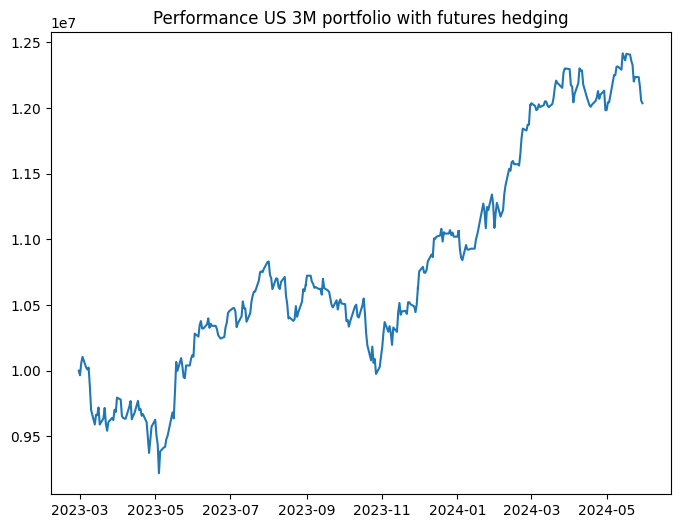

In [188]:
print(df_value.iloc[-1,0])
plt.figure(figsize=(8, 6))
plt.title(f'Performance {country} {frequency} portfolio with futures hedging')
plt.plot(df_value)


### IV. Analyse for Hedge Impact

In [189]:
# Application of the strategy: construct portfolio without hedging strategies
pt_value = get_point_value(country)

blp = BLP()
strFields_nohedge = ["PX_LAST"]
value_ptf_nohedge = Capital
print("captial == ", value_ptf_nohedge)
df_nohedge_ptf = pd.DataFrame(columns=['ptf_value'])

for t in range(df_database.shape[1]):
    ptf_memb_cur = df_database.iloc[:,t] # get columns
    ptf_memb_cur.dropna(inplace=True)  # get components of our portfolio at time t

    bgn_date = pd.to_datetime(df_database.columns[t])
    # if the bgn_date is in the same month of today, we get the PX_LAST until today, otherwise we get the daily price for the whole month
    if t < df_database.shape[1]-1:
        end_date = pd.to_datetime(df_database.columns[t+1])
    elif bgn_date + timedelta(days=30) > today:
        end_date = today
    else:
        end_date = bgn_date + timedelta(days=30)
    print("t = ",t)
    valid_bgn_date = mcal.date_range(nyse.schedule(start_date=bgn_date, end_date=end_date), frequency='1D')[0]
    valid_end_date = mcal.date_range(nyse.schedule(start_date=end_date, end_date=end_date+timedelta(days=7)), frequency='1D')[0]


    tickers = ptf_memb_cur.tolist()
    df_price = run_bloomberg(tickers, strFields_nohedge, valid_bgn_date, valid_end_date)
    df_ptf_quantity, cash_liquid = buying_new_components(tickers, 0, value_ptf_nohedge, 1, df_price)
    if t ==0:
        df_nohedge_ptf = calculate_ptf_value(df_ptf_quantity, df_price, cash_liquid)
    else:
        df_nohedge_new = calculate_ptf_value(df_ptf_quantity, df_price, cash_liquid)
        df_nohedge_ptf = pd.concat([df_nohedge_ptf, df_nohedge_new])
    value_ptf_nohedge = df_nohedge_ptf.iloc[-1,0] 


captial ==  10000000.0
t =  0
t =  1
t =  2
t =  3
t =  4
t =  5
t =  6
t =  7
t =  8
t =  9
t =  10
t =  11
t =  12
t =  13
t =  14


11473049.722350013


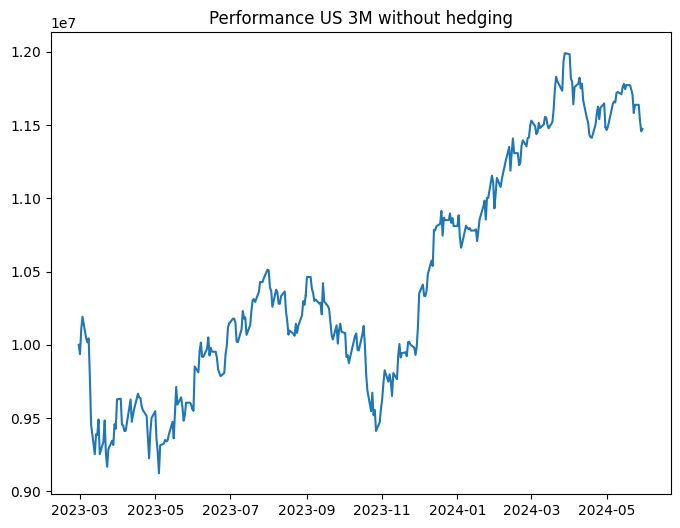

In [190]:
print(df_nohedge_ptf.iloc[-1,0])
plt.figure(figsize=(8, 6))
plt.title(f'Performance {country} {frequency} without hedging')
plt.plot(df_nohedge_ptf)

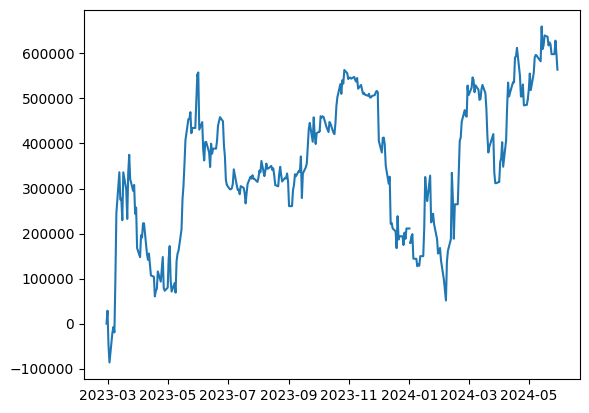

In [191]:
df_hedge_pnl = df_value - df_nohedge_ptf
plt.plot(df_hedge_pnl)
nbre=0
negative_pnl=0


In [192]:

# creation of object "Performance"
performance = Performance_Analysis(df_value)
#daily_return = performance.daily_return()
TotalReturn = 100* performance.overall_performance()
annualized_return = 100* performance.annualized_return()

return2023 = 100* (df_value.loc[dt.date(2023, 12, 29), 'ptf_value']/df_value.loc[dt.date(2023, 2, 28), 'ptf_value'] - 1)
return2024 = 100* (df_value.iloc[-1,0]/df_value.loc[dt.date(2024, 1, 3)][0]- 1)
monthly_analysis = performance.month_analysis()

df_statistics = pd.DataFrame({'Value in %':[annualized_return, TotalReturn, return2024, return2023, monthly_analysis.iloc[0,1], monthly_analysis.iloc[1,1]]},
                             index=['Annualized Return', 'Total Return', '2024 Return', '2023 Return', 'Best Montly Return', 'Worst Montly Return'])
print(f"\n{country} Lookback {frequency} Portfolio Statistics:")
print(df_statistics)

# get the risk-free rate
index_riskfreerate = Rf_index(country)
index_rf = index_riskfreerate.rf_Index()
rf_yearly = run_bloomberg(index_rf, ['PX_LAST'], valid_end_date, valid_end_date)
rf = rf_yearly / (100*365)

annualized_std = performance.volatility('yearly')
M_DD = performance.Maximum_DD().iloc[-1,0]
SH_P = performance.Sharpe_Ratio(rf)
VaR_5 = performance.hist_VaR(0.05)
VaR_1 = performance.hist_VaR(0.01)
df_ratio = pd.DataFrame({'Ratio':[annualized_std, M_DD, SH_P, VaR_5, VaR_1]},
                        index=['Annualized standard deviation', 'Maximum Drawdown', 'Sharpe Ratio', 'Historical VaR 5%', 'Historical VaR 1%'])


print(f"\n{country} Lookback {frequency} Portfolio Risks & Returns:")
print(df_ratio)

C:\Users\Xinzhuo\AppData\Local\Temp/ipykernel_33448/941284486.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return2024 = 100* (df_value.iloc[-1,0]/df_value.loc[dt.date(2024, 1, 3)][0]- 1)
c:\Users\Xinzhuo\Desktop\BBG XiyuXUE, XinzhuoPENG\Performance.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_r = df.resample('M').apply(lambda x: (x.iloc[-1] / x.iloc[0] - 1) * 100)
c:\Users\Xinzhuo\Desktop\BBG XiyuXUE, XinzhuoPENG\Performance.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_result = self.df_ptf.iloc[:,0].pct_change()
c:\Use


US Lookback 3M Portfolio Statistics:
                     Value in %
Annualized Return     15.960610
Total Return          20.370554
2024 Return           10.155165
2023 Return           10.208823
Best Montly Return     7.322004
Worst Montly Return   -3.824959

US Lookback 3M Portfolio Risks & Returns:
                                  Ratio
Annualized standard deviation  0.106736
Maximum Drawdown              -0.257589
Sharpe Ratio                   1.039425
Historical VaR 5%             -3.917536
Historical VaR 1%             -5.823838
